In [57]:
from mintpy.utils import *
import mintpy.utils as mpu
import mintpy.utils.readfile
import mintpy.utils.utils
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [58]:
sns.set_theme()
sns.set_style("ticks")
sns.set_context("paper")
# sns.set_theme(style="white") #, font_scale=0.5)
plt.style.use(['seaborn-paper', 'seaborn-ticks'])
sns.set_color_codes()

In [59]:
matplotlib.rcParams['lines.linewidth']
matplotlib.rcParams['axes.linewidth']
plt.style.available
matplotlib.use("pgf")
matplotlib.rcParams.update({    
    'font.family': 'serif',
    'font.serif': [],       # use latex default serif font
    'font.sans-serif': [],  # use a specific sans-serif font
    'font.monospace': [],   # use a specific sans-serif font
    'text.usetex': True,
    'pgf.rcfonts': False,
    'pgf.texsystem': 'pdflatex',
    'lines.linewidth': 0.7,
    'axes.linewidth': 0.6,
    'axes.unicode_minus': False
})

golden_ratio = (5**.5 - 1) / 2

width  = 3.48761
height = width*golden_ratio
print(width,height)

3.48761 2.155461519504021


In [60]:
mask_data, mask_attr = mpu.readfile.read('/data1/data/sar_isb_dumps/mintpy/maskROI.h5')

In [61]:
plt.imshow(mask_data)

In [62]:
mask_data_temp, mask_attr_temp = mpu.readfile.read('/data1/data/sar_isb_dumps/mintpy/_Isc/maskTempCoh.h5')
plt.imshow(mask_data_temp)

In [63]:
plt.imshow(mask_data*mask_data_temp)
mask_data = mask_data*mask_data_temp

In [64]:
ts_file = '/data1/data/sar_isb_dumps/mintpy/_Isc/timeseries_ERA5_ramp_demErr.h5'

In [65]:
ts_data, ts_attr = mpu.readfile.read(ts_file)

In [66]:
from mintpy.objects import (
    geometryDatasetNames,
    geometry,
    ifgramStack,
    timeseries,
)
from mintpy.utils import ptime, readfile

In [67]:
obj = timeseries(ts_file)

In [68]:
dates, dis = mpu.utils.read_timeseries_yx(0,0, ts_file=ts_file)

input y / x: 0 / 0


In [69]:
ts_attr

{'ALOOKS': '2',
 'ANTENNA_SIDE': '-1',
 'AZIMUTH_PIXEL_SIZE': '36.90020546733459',
 'CENTER_LINE_UTC': '14734.0',
 'DATA_TYPE': 'float32',
 'DATE12': '171204-180202',
 'EARTH_RADIUS': '6368718.889498402',
 'END_DATE': '20201224',
 'FILE_LENGTH': '1107',
 'LENGTH': '37',
 'FILE_PATH': '/data1/data/sar_isb_dumps/mintpy/_Isc/timeseries_ERA5_ramp_demErr.h5',
 'FILE_TYPE': 'timeseries',
 'HEADING': '-1.664352959066593e+02',
 'HEIGHT': '701284.8644845383',
 'INCIDENCE_ANGLE': '3.910847785139392e+01',
 'LAT_REF1': '41.0716219233434',
 'LAT_REF2': '41.2167943098809',
 'LAT_REF3': '40.90606367448475',
 'LAT_REF4': '41.05126523100622',
 'LONG_REF1': '30.39682612423794',
 'LONG_REF2': '29.29556944192746',
 'LONG_REF3': '30.3567438684797',
 'LONG_REF4': '29.25834460312059',
 'ORBIT_DIRECTION': 'DESCENDING',
 'PLATFORM': 'sen',
 'PRF': '1717.128973878037',
 'PROCESSOR': 'snap',
 'PROJECT_NAME': 'mintpy',
 'P_BASELINE_BOTTOM_HDR': '9.704228401184082',
 'P_BASELINE_TOP_HDR': '9.704228401184082',
 'RA

<ipython-input-70-73eab79ec204>:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


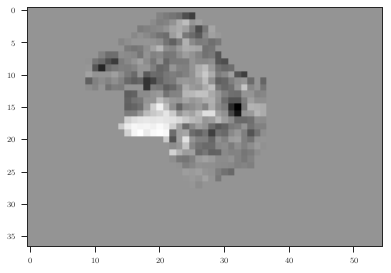

In [70]:
fig = plt.figure()
plt.imshow(ts_data[1]*mask_data);
fig

In [71]:
ts_cum_sum = (ts_data*mask_data).sum(axis=(1,2))
ts_cum_sum.shape

(91,)

In [72]:
df_ts_data = pd.DataFrame(ts_cum_sum, columns=['Displacement'], index=pd.DatetimeIndex(dates))

In [73]:
df_ts_data = df_ts_data.resample('12D').mean().rename(columns=lambda x: 'Displacement')

In [74]:
try:
    a = open('/data1/data/sar_isb_dumps/mintpy/_Isc/exclude_date.txt').readlines()
except:
    a = []
a.append('20191112\n') #Missing data from S1
# a.append('20191230\n')
a

['20191112\n']

In [75]:
df_ts_data['Count'] = 1

In [76]:
for i in a:    
    df_ts_data.loc[i[:8]:i[:8]] = 0

In [77]:
df_ts_data['Days'] = 1

In [78]:
df_ts_data.Displacement *= 365
df_ts_data.Displacement /= 12

In [79]:
df_ts_B = pd.DataFrame(ts_cum_sum, columns=['Displacement'], index=pd.DatetimeIndex(dates))
for i in a:    
    df_ts_B.loc[i[:8]:i[:8]] = None
df_ts_B  = df_ts_B['2018-01-01':]
df_ts_B.Displacement *= 365
df_ts_B.Displacement /= 12

In [80]:
df_ts_Q = df_ts_data.resample('D').last()
df_ts_Q = df_ts_Q.bfill(limit=11) \
                 .resample('Q') \
                 .sum()['2018-01-01':]
df_ts_Q['Velocity'] = df_ts_Q.Displacement/df_ts_Q.Count
df_ts_Q['Adj_Displacement'] = df_ts_Q.Velocity*df_ts_Q.Days
# df_ts_Q.Velocity -= df_ts_Q.Velocity.iloc[0]
df_ts_Q['Acceleration'] = df_ts_Q.Velocity.diff()
df_ts_Q

,Displacement,Count,Days,Velocity,Adj_Displacement,Acceleration
2018-03-31,1874.788208,90.0,90.0,20.830980,1874.788208,NaN
2018-06-30,6423.777344,91.0,91.0,70.590960,6423.777344,49.759980
2018-09-30,9580.080078,92.0,92.0,104.131305,9580.080078,33.540345
2018-12-31,9417.612305,92.0,92.0,102.365351,9417.612305,-1.765954
2019-03-31,12147.251953,90.0,90.0,134.969466,12147.251953,32.604115
2019-06-30,13387.355469,91.0,91.0,147.113796,13387.355469,12.144330
2019-09-30,16348.591797,92.0,92.0,177.702085,16348.591797,30.588288
2019-12-31,16933.144531,80.0,92.0,211.664307,19473.116211,33.962222
2020-03-31,19222.410156,91.0,91.0,211.235276,19222.410156,-0.429030
2020-06-30,20918.812500,91.0,91.0,229.877060,20918.812500,18.641784


In [81]:
df_ts_M = df_ts_data.resample('D').last()
df_ts_M = df_ts_M.bfill(limit=11) \
                 .resample('M') \
                 .sum()['2018-01-01':]
df_ts_M['Velocity'] = df_ts_M.Displacement/df_ts_M.Count
df_ts_M['Adj_Displacement'] = df_ts_M.Velocity*df_ts_M.Days
# df_ts_M.Velocity -= df_ts_M.Velocity.iloc[0]
df_ts_M['Acceleration'] = df_ts_M.Velocity.diff()
df_ts_M

,Displacement,Count,Days,Velocity,Adj_Displacement,Acceleration
2018-01-31,359.443024,31.0,31.0,11.594936,359.443024,NaN
2018-02-28,311.852570,28.0,28.0,11.137592,311.852570,-0.457344
2018-03-31,1203.492676,31.0,31.0,38.822344,1203.492676,27.684753
2018-04-30,1824.936646,30.0,30.0,60.831222,1824.936646,22.008877
2018-05-31,1966.872314,31.0,31.0,63.447494,1966.872314,2.616272
2018-06-30,2631.968506,30.0,30.0,87.732284,2631.968506,24.284790
2018-07-31,2724.429932,31.0,31.0,87.884837,2724.429932,0.152553
2018-08-31,3511.048096,31.0,31.0,113.259616,3511.048096,25.374779
2018-09-30,3344.601807,30.0,30.0,111.486727,3344.601807,-1.772889
2018-10-31,2876.503906,31.0,31.0,92.790449,2876.503906,-18.696278


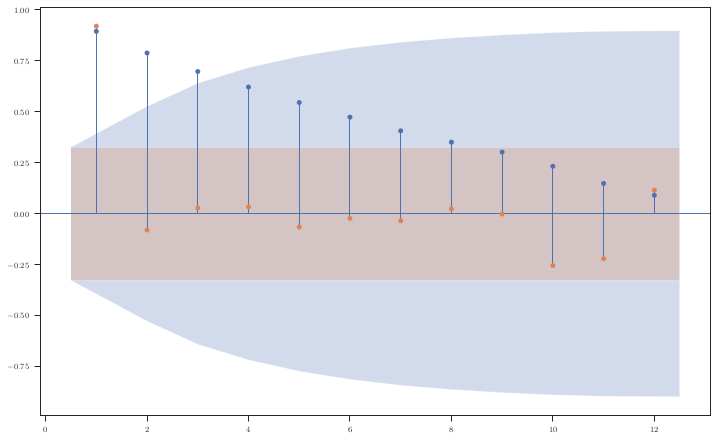

In [103]:
fig = plt.figure(figsize=(12,7.5))
ax = fig.subplots()
plot_acf(df_ts_M.Velocity, zero=False, ax=ax, lags=12)
plot_pacf(df_ts_M.Velocity, zero=False, ax=ax, lags=12)
ax.set_title(None)
fig

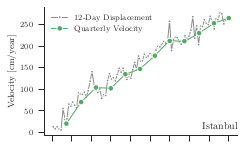

In [101]:
fig = plt.figure(figsize=(width,height))
ax1 = fig.subplots()
sns.lineplot(data=df_ts_B.Displacement, marker='.', color='C7', ax=ax1);
sns.lineplot(data=df_ts_Q.Velocity, marker='o', color='C2', ax=ax1)
ax1.set_ylabel(r'Velocity [cm/year]')
plt.legend(ax1.lines,["12-Day Displacement"]+["Quarterly Velocity"], loc='upper left')
sns.despine(right=True, trim=False)
fig.autofmt_xdate()
ax1.set_xlabel(None)
ax1.set_xticklabels([])
ax1.text(1.0,0.05,'Istanbul',
        horizontalalignment='right',
        verticalalignment='bottom',
        transform=ax1.transAxes)
fig.tight_layout()
fig.savefig("pgf/isb_displacement_velocity.pgf", backend='pgf', dpi=600)
fig

In [84]:
stringency = pd.read_csv("/data1/data/stringency_index.csv", index_col=1, parse_dates=True, )
stringency = stringency.T
stringency = stringency[2:] 
stringency.index = pd.DatetimeIndex(stringency.index)

In [85]:
STR = stringency['TUR'].astype(float)
df_ts_Q['Stringency'] = STR.resample('Q') \
                           .mean()['2018-01-01':] 
df_ts_Q['Stringency'].fillna(0, inplace=True)

In [86]:
STR = stringency['TUR'].astype(float)
df_ts_M['Stringency'] = STR.resample('M') \
                           .mean()['2018-01-01':] 
df_ts_M['Stringency'].fillna(0, inplace=True)

In [87]:
country = "Turkey_Seasonal"
GDP = pd.read_csv("/data1/data/GDP.csv" )
GDP.index = pd.DatetimeIndex(GDP.Date)
GDP = GDP.resample('Q').max()
df_ts_Q.loc[:, "GDP"] = GDP[country]

GDP_M = (GDP[country]).resample('M').last()
GDP_M['2020-10-31'] = np.NaN
GDP_M['2020-11-30'] = np.NaN
GDP_M['2020-12-31'] = np.NaN

GDP_Q = GDP[country]

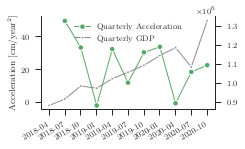

In [88]:
fig = plt.figure(figsize=(width,height))
ax1 = sns.lineplot(data=df_ts_Q.Acceleration.loc[:'2020-09-30'], marker='o', color='C2');
ax1.set_ylabel(r'Acceleration [cm/year\textsuperscript{2}]')
# ax1.set_ylabel(None)
ax2 = plt.twinx()
sns.lineplot(data=df_ts_Q.GDP, ax=ax2, marker='.', color='C7')
# ax2.set_ylabel(r'GDP [\textcurrency]')
ax2.set_ylabel(None)
ax2.set_ylim(top=1350000)
plt.legend(ax1.lines+ax2.lines, ["Quarterly Acceleration"]+["Quarterly GDP"], loc='upper center')
sns.despine(right=False, trim=False);
fig.autofmt_xdate()
fig.tight_layout()
fig.savefig("pgf/isb_acceleration.pgf", backend='pgf', dpi=600)
fig

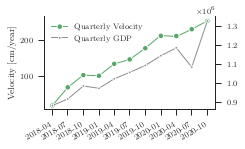

In [89]:
fig = plt.figure(figsize=(width,height))
ax1 = sns.lineplot(data=df_ts_Q.Velocity.loc[:'2020-09-30'], marker='o', color='C2')
ax1.set_ylabel(r'Velocity [cm/year]')
ax2 = plt.twinx()
sns.lineplot(data=df_ts_Q.GDP, ax=ax2, marker='.', color='C7')
# ax2.set_ylabel(r'GDP [\textcurrency]')
ax2.set_ylabel(None)
plt.legend(ax1.lines+ax2.lines, ["Quarterly Velocity"]+["Quarterly GDP"], loc='upper left')
sns.despine(right=False, trim=False);
fig.autofmt_xdate()
fig.tight_layout()
fig.savefig("pgf/isb_velocity_GDP.pgf", backend='pgf', dpi=600)
fig

In [90]:
df_ts_M['GDP_naive']      = (df_ts_Q.GDP).resample('M').last()
df_ts_M.GDP_naive         =  df_ts_M.GDP_naive.bfill()
df_ts_M['GDP'] = GDP_M.reset_index() \
                      .interpolate(method='spline', order=3) \
                      .set_index('Date') \
                      .shift(-1)[:'2020-09-30']
df_ts_M 

,Displacement,Count,Days,Velocity,Adj_Displacement,Acceleration,Stringency,GDP_naive,GDP
2018-01-31,359.443024,31.0,31.0,11.594936,359.443024,NaN,0.000000,882477.0,8.751346e+05
2018-02-28,311.852570,28.0,28.0,11.137592,311.852570,-0.457344,0.000000,882477.0,8.824770e+05
2018-03-31,1203.492676,31.0,31.0,38.822344,1203.492676,27.684753,0.000000,882477.0,8.895201e+05
2018-04-30,1824.936646,30.0,30.0,60.831222,1824.936646,22.008877,0.000000,917009.0,8.997366e+05
2018-05-31,1966.872314,31.0,31.0,63.447494,1966.872314,2.616272,0.000000,917009.0,9.170090e+05
2018-06-30,2631.968506,30.0,30.0,87.732284,2631.968506,24.284790,0.000000,917009.0,9.428324e+05
2018-07-31,2724.429932,31.0,31.0,87.884837,2724.429932,0.152553,0.000000,985413.0,9.691236e+05
2018-08-31,3511.048096,31.0,31.0,113.259616,3511.048096,25.374779,0.000000,985413.0,9.854130e+05
2018-09-30,3344.601807,30.0,30.0,111.486727,3344.601807,-1.772889,0.000000,985413.0,9.850711e+05
2018-10-31,2876.503906,31.0,31.0,92.790449,2876.503906,-18.696278,0.000000,973417.0,9.768689e+05


In [91]:
dates_prior = slice('2018-01-01','2019-12-31')
dates_full = slice('2018-01-01','2020-08-31')

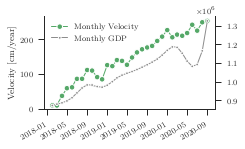

In [92]:
fig = plt.figure(figsize=(width,height))
ax1 = sns.lineplot(data=df_ts_M.Velocity.loc[dates_full], marker='o', color='C2')
ax1.set_ylabel(r'Velocity [cm/year]')
ax2 = plt.twinx()
# sns.lineplot(data=df_ts_M.GDP_naive.loc[dates_full], ax=ax2, marker='.', color='C1')
sns.lineplot(data=df_ts_M.GDP.loc[dates_full], ax=ax2, marker='.', color='C7')
# ax2.set_ylabel(r'GDP [\textcurrency]')
ax2.set_ylabel(None)
# ax2.set_ylim(top=1350000)
plt.legend(ax1.lines+ax2.lines, ["Monthly Velocity"]+["Monthly GDP"], loc='upper left')
sns.despine(right=False, trim=False);
fig.autofmt_xdate()
fig.tight_layout()
fig.savefig("pgf/isb_velocity_GDP_monthly.pgf", backend='pgf', dpi=600)
fig

In [93]:
import statsmodels.api as sm
X_var = ['GDP']
dates = slice('2018-01-31','2019-12-31')
X = df_ts_M.loc[dates_prior, X_var]
y = df_ts_M.Velocity[dates_prior]
X = sm.add_constant(X)
# X['trend'] = range(1,len(X)+1)
# Note the difference in argument order
model = sm.OLS(y, X).fit(cov_type='HAC',cov_kwds={'maxlags':12})
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Velocity   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     787.6
Date:                Fri, 05 Mar 2021   Prob (F-statistic):           1.02e-18
Time:                        09:05:38   Log-Likelihood:                -91.022
No. Observations:                  24   AIC:                             186.0
Df Residuals:                      22   BIC:                             188.4
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -566.3039     25.375    -22.317      0.000    -616.039    -516.569
GDP            0.0007   2.42e-05     28.065      0.000       0.001       0.001
==============================================================================
Omnibus:                        0.426   Durbin-Watson:                   1.388
Prob(Omnibus):                  0.808   Jarque-Bera (JB):                0.062
Skew:                          -0.124   Prob(JB):                        0.970
Kurtosis:                       3.015   Cond. No.                     1.23e+07
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 12 lags and without small sample correction
[2] The condition number is large, 1.23e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [94]:
import statsmodels.api as sm
X_var = ['GDP']
X = df_ts_M.loc[dates_full, X_var]
y = df_ts_M.Velocity[dates_full]
X = sm.add_constant(X)
# X['trend'] = range(1,len(X)+1)
# Note the difference in argument order
model = sm.OLS(y, X).fit(cov_type='HAC',cov_kwds={'maxlags':12})
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Velocity   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     143.2
Date:                Fri, 05 Mar 2021   Prob (F-statistic):           6.01e-13
Time:                        09:05:38   Log-Likelihood:                -147.40
No. Observations:                  32   AIC:                             298.8
Df Residuals:                      30   BIC:                             301.7
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -494.9674     56.419     -8.773      0.000    -605.546    -384.389
GDP            0.0006   5.12e-05     11.965      0.000       0.001       0.001
==============================================================================
Omnibus:                        6.955   Durbin-Watson:                   0.957
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                7.863
Skew:                           0.430   Prob(JB):                       0.0196
Kurtosis:                       5.271   Cond. No.                     1.06e+07
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 12 lags and without small sample correction
[2] The condition number is large, 1.06e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [95]:
import statsmodels.api as sm
X_var = ['GDP','Stringency']
X = df_ts_M.loc[dates_full, X_var]
y = df_ts_M.Velocity[dates_full]
X = sm.add_constant(X)
# X['trend'] = range(0,len(X))
# Note the difference in argument order
model = sm.OLS(y, X).fit(cov_type='HAC',cov_kwds={'maxlags':12})
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Velocity   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     142.2
Date:                Fri, 05 Mar 2021   Prob (F-statistic):           1.03e-15
Time:                        09:05:38   Log-Likelihood:                -141.30
No. Observations:                  32   AIC:                             288.6
Df Residuals:                      29   BIC:                             293.0
Df Model:                           2                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -431.5061     80.813     -5.340      0.000    -589.896    -273.116
GDP            0.0005   7.82e-05      6.975      0.000       0.000       0.001
Stringency     0.6348      0.172      3.680      0.000       0.297       0.973
==============================================================================
Omnibus:                       15.600   Durbin-Watson:                   1.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.366
Skew:                          -1.337   Prob(JB):                     0.000103
Kurtosis:                       5.573   Cond. No.                     1.16e+07
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 12 lags and without small sample correction
[2] The condition number is large, 1.16e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [96]:
import statsmodels.api as sm
X_var = ['GDP','Stringency']
dates = slice('2018-03-31','2020-09-30')
X = df_ts_Q.loc[dates, X_var]
y = df_ts_Q.Velocity[dates]
X = sm.add_constant(X)
# X['trend'] = range(1,len(X)+1)
# Note the difference in argument order
model = sm.OLS(y, X).fit(cov_type='HAC',cov_kwds={'maxlags':4})
X_all = df_ts_Q.loc[dates, X_var]
X_all.Stringency = 0.0
X_all = sm.add_constant(X_all)
# X_all['trend'] = range(1,len(X)+1)
predictions = model.predict(X_all) # make the predictions by the model
# Print out the statistics
model.summary()

/home/tvanzyl/anaconda3/envs/mintpy/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Velocity   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     43.05
Date:                Fri, 05 Mar 2021   Prob (F-statistic):           5.22e-05
Time:                        09:05:38   Log-Likelihood:                -50.566
No. Observations:                  11   AIC:                             107.1
Df Residuals:                       8   BIC:                             108.3
Df Model:                           2                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -343.7786    112.420     -3.058      0.002    -564.117    -123.440
GDP            0.0005      0.000      4.263      0.000       0.000       0.001
Stringency     0.5579      0.310      1.798      0.072      -0.050       1.166
==============================================================================
Omnibus:                        0.978   Durbin-Watson:                   1.627
Prob(Omnibus):                  0.613   Jarque-Bera (JB):                0.604
Skew:                          -0.525   Prob(JB):                        0.740
Kurtosis:                       2.537   Cond. No.                     1.10e+07
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 4 lags and without small sample correction
[2] The condition number is large, 1.1e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [97]:
df_ts_Q["Prediction"] = predictions
df_ts_Q["Residual_Velocity"] = (df_ts_Q.Velocity-df_ts_Q.Prediction)

In [98]:
df_ts_Q.loc['20180101':'20191231',['Velocity','Adj_Displacement','Acceleration','GDP','Residual_Velocity']].corr()

,Velocity,Adj_Displacement,Acceleration,GDP,Residual_Velocity
Velocity,1.000000,0.999847,-0.045704,0.991223,0.966428
Adj_Displacement,0.999847,1.000000,-0.047375,0.991320,0.965797
Acceleration,-0.045704,-0.047375,1.000000,-0.082035,0.054067
GDP,0.991223,0.991320,-0.082035,1.000000,0.923979
Residual_Velocity,0.966428,0.965797,0.054067,0.923979,1.000000


In [99]:
df_ts_Q.loc['20180101':'20200930',['Velocity','Adj_Displacement','Acceleration','GDP','Residual_Velocity','Stringency']].corr()

,Velocity,Adj_Displacement,Acceleration,GDP,Residual_Velocity,Stringency
Velocity,1.000000,0.999877,-0.275029,0.923914,0.632586,0.666543
Adj_Displacement,0.999877,1.000000,-0.271779,0.926231,0.627588,0.663984
Acceleration,-0.275029,-0.271779,1.000000,-0.272102,-0.078354,-0.210186
GDP,0.923914,0.926231,-0.272102,1.000000,0.288135,0.577757
Residual_Velocity,0.632586,0.627588,-0.078354,0.288135,1.000000,0.498713
Stringency,0.666543,0.663984,-0.210186,0.577757,0.498713,1.000000


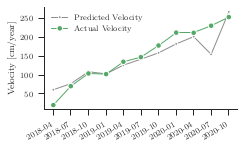

In [100]:
fig = plt.figure(figsize=(width,height))
ax = sns.lineplot(data=df_ts_Q.Prediction, marker='.', color='C7')
sns.lineplot(data=df_ts_Q.Velocity.loc[dates], marker='o', color='C2', ax=ax)
ax.set_ylabel(r'Velocity [cm/year]')
plt.legend(["Predicted Velocity","Actual Velocity"], loc='upper left')
sns.despine(trim=False);
fig.autofmt_xdate()
fig.tight_layout()
fig.savefig("pgf/isb_predicted_velocity.pgf", backend='pgf', dpi=600)
fig